# Plot centromere pileup ratio
## Library

In [80]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [81]:
# import libraries for biological data analysis
import cooler
import bioframe

import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

## Parameters

In [82]:
flank = 100_000
ind_dict = {
    'rec8d':'1', 
    'wt':'2', 
    'rec8-14D':'3', 
    'rec8-24A':'4'
}
strain_name = 'rec8d'

## Load data

In [83]:
data_dir = 'cooler_out'
# Open cool file with Micro-C data:
clr = cooler.Cooler(data_dir + '/HiC' + ind_dict[strain_name] + '.mcool::/resolutions/1000')
resolution = clr.binsize

## Load features

In [84]:
cens = bioframe.read_table('sk1_cen.bed', schema='bed')
cens['mid'] = (cens.end + cens.start)//2
cens.head()

,chrom,start,end,name,score,strand,mid
0,chrI,160506,160623,NaN,NaN,NaN,160564
1,chrII,229855,229971,NaN,NaN,NaN,229913
2,chrIII,119146,119262,NaN,NaN,NaN,119204
3,chrIV,461938,462053,NaN,NaN,NaN,461995
4,chrV,156659,156776,NaN,NaN,NaN,156717


In [85]:
# pre_chromsizes = bioframe.read_table('SK1.chrom.sizes')
# data = np.copy(pre_chromsizes[1])
# index = np.copy(pre_chromsizes[0])
# chromsizes = pd.Series(data, index)
# chromsizes = chromsizes[:-2]
# chromsizes.name = 'length'
# chromsizes.head()

In [86]:
# hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
# print(hg38_chromsizes)
# hg38_cens = bioframe.fetch_centromeres('hg38')
# print(hg38_cens)
# hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
# print(hg38_arms)

In [87]:
# arms = bioframe.make_chromarms(chromsizes, cens)
# arms.head()

## Feature inspection and filtering

In [88]:
sites = cens

## On-diagonal pileup

In [89]:
# create view_df (somehow the default option did not work)
cooler_view = bioframe.make_viewframe(clr.chromsizes)
cooler_view.head()

,chrom,start,end,name
0,chrI,0,258084,chrI
1,chrII,0,804360,chrII
2,chrIII,0,336578,chrIII
3,chrIV,0,1530282,chrIV
4,chrV,0,591864,chrV


In [90]:
stack = cooltools.pileup(clr, sites, view_df=cooler_view, flank=flank)
mtx = np.nanmean(stack, axis=2)
save_mtx = pd.DataFrame(mtx)
save_mtx.to_csv('intermediate/' + strain_name + '.csv', index=False)

In [91]:
# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:
import cooltools.lib.plotting

/var/folders/sx/cg2lr_vj0x387p3v3l2qbp080000gn/T/ipykernel_31451/1593872358.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(mtx),


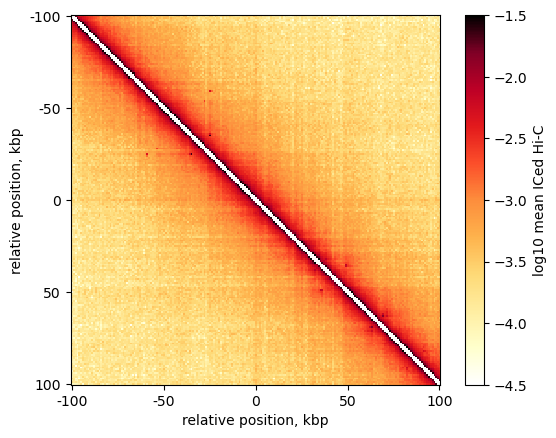

In [92]:
plt.imshow(
    np.log10(mtx),
    vmin = -4.5,
    vmax = -1.5,
    cmap='fall',
    interpolation='none')

plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution, 5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.savefig('figures/cen_pileup_' + strain_name + '.png', dpi=300)
plt.show()